<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/GBM(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# ============================================================================
print("STEP 1: Importing required libraries...")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score,
                           f1_score, precision_recall_fscore_support, log_loss)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")
print("✓ Libraries imported successfully!")

STEP 1: Importing required libraries...
✓ Libraries imported successfully!


In [2]:
# ============================================================================
# STEP 2: DEFINE THE CLASSIFIER CLASS
# ============================================================================
print("\nSTEP 2: Defining the classifier class...")

class GBMProductionClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42):
        """Initialize GBM classifier with parameters"""
        self.model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=random_state,
            verbose=1
        )
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.quantiles = None
        # Initialize tracking variables for loss and accuracy
        self.train_scores = []
        self.val_scores = []
        self.train_losses = []
        self.val_losses = []

    def load_data(self, train_path, validation_path, test_path):
        """Load and prepare datasets"""
        print("\nSTEP 3A: Loading datasets...")
        self.train_df = pd.read_csv(train_path)
        self.validation_df = pd.read_csv(validation_path)
        self.test_df = pd.read_csv(test_path)

        print(f"✓ Train dataset shape: {self.train_df.shape}")
        print(f"✓ Validation dataset shape: {self.validation_df.shape}")
        print(f"✓ Test dataset shape: {self.test_df.shape}")
        return self

    def create_quantile_labels(self):
        """Create 3-level quantile-based labels for production levels"""
        print("\nSTEP 4A: Creating 3-level quantile-based labels...")

        production_col = 'Production (M.Ton)'
        production_values = self.train_df[production_col]

        # Changed to 3 levels using 33rd and 67th percentiles
        self.quantiles = {
            '33%': production_values.quantile(0.33),
            '67%': production_values.quantile(0.67)
        }

        print(f"✓ Quantile thresholds calculated:")
        for q, val in self.quantiles.items():
            print(f"  {q}: {val:.2f}")

        def categorize_production(value):
            """Categorize production into 3 levels"""
            if value <= self.quantiles['33%']:
                return 'Low'
            elif value <= self.quantiles['67%']:
                return 'Medium'
            else:
                return 'High'

        # Apply categorization to all datasets
        self.train_df['Production_Category'] = self.train_df[production_col].apply(categorize_production)
        self.validation_df['Production_Category'] = self.validation_df[production_col].apply(categorize_production)
        self.test_df['Production_Category'] = self.test_df[production_col].apply(categorize_production)

        print("✓ Production category distribution in training data:")
        distribution = self.train_df['Production_Category'].value_counts().sort_index()
        for category, count in distribution.items():
            print(f"  {category}: {count}")

        return self

    def prepare_features(self):
        """Prepare features for modeling"""
        print("\nSTEP 5A: Preparing features...")

        # Select feature columns (exclude target variables)
        feature_cols = [col for col in self.train_df.columns
                       if col not in ['Production (M.Ton)', 'Production_Category']]
        print(f"✓ Selected {len(feature_cols)} feature columns")

        # Prepare feature matrices and target vectors
        self.X_train = self.train_df[feature_cols]
        self.y_train = self.train_df['Production_Category']
        self.X_val = self.validation_df[feature_cols]
        self.y_val = self.validation_df['Production_Category']
        self.X_test = self.test_df[feature_cols]
        self.y_test = self.test_df['Production_Category']

        # Handle missing values
        self.X_train = self.X_train.fillna(self.X_train.mean())
        self.X_val = self.X_val.fillna(self.X_train.mean())
        self.X_test = self.X_test.fillna(self.X_train.mean())

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # Encode categorical labels
        self.y_train_encoded = self.label_encoder.fit_transform(self.y_train)
        self.y_val_encoded = self.label_encoder.transform(self.y_val)
        self.y_test_encoded = self.label_encoder.transform(self.y_test)

        print(f"✓ Feature matrix shape: {self.X_train_scaled.shape}")
        print(f"✓ Target classes: {list(self.label_encoder.classes_)}")
        return self

    def train_model(self, n_epochs=100):
        """Train the GBM model with staged predictions"""
        print(f"\nSTEP 6A: Training GBM model for {n_epochs} epochs...")

        self.model.set_params(n_estimators=n_epochs)
        self.model.fit(self.X_train_scaled, self.y_train_encoded)

        print("STEP 6D: Computing staged predictions for training curves...")
        train_staged_pred = list(self.model.staged_predict(self.X_train_scaled))
        val_staged_pred = list(self.model.staged_predict(self.X_val_scaled))
        train_staged_pred_proba = list(self.model.staged_predict_proba(self.X_train_scaled))
        val_staged_pred_proba = list(self.model.staged_predict_proba(self.X_val_scaled))

        # Calculate accuracy and loss for each epoch
        train_scores = []
        val_scores = []
        train_losses = []
        val_losses = []

        for i in range(len(train_staged_pred)):
            train_acc = accuracy_score(self.y_train_encoded, train_staged_pred[i])
            val_acc = accuracy_score(self.y_val_encoded, val_staged_pred[i])
            train_scores.append(train_acc)
            val_scores.append(val_acc)

            train_loss = log_loss(self.y_train_encoded, train_staged_pred_proba[i])
            val_loss = log_loss(self.y_val_encoded, val_staged_pred_proba[i])
            train_losses.append(train_loss)
            val_losses.append(val_loss)

        self.train_scores = train_scores
        self.val_scores = val_scores
        self.train_losses = train_losses
        self.val_losses = val_losses

        print("✓ Training completed!")
        return self

    def evaluate_model(self, X, y, y_encoded, dataset_name):
        """Evaluate model performance"""
        y_pred_encoded = self.model.predict(X)
        y_pred = self.label_encoder.inverse_transform(y_pred_encoded)

        accuracy = accuracy_score(y_encoded, y_pred_encoded)
        precision_macro = precision_score(y_encoded, y_pred_encoded, average='macro')
        precision_weighted = precision_score(y_encoded, y_pred_encoded, average='weighted')
        recall_macro = recall_score(y_encoded, y_pred_encoded, average='macro')
        recall_weighted = recall_score(y_encoded, y_pred_encoded, average='weighted')
        f1_macro = f1_score(y_encoded, y_pred_encoded, average='macro')
        f1_weighted = f1_score(y_encoded, y_pred_encoded, average='weighted')

        results = {
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'precision_weighted': precision_weighted,
            'recall_macro': recall_macro,
            'recall_weighted': recall_weighted,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'y_true': y,
            'y_pred': y_pred,
            'y_true_encoded': y_encoded,
            'y_pred_encoded': y_pred_encoded
        }
        return results

    def print_classification_metrics(self, results, dataset_name):
        """Print classification metrics"""
        print(f"\n{'='*50}")
        print(f"STEP 8A: {dataset_name.upper()} DATASET METRICS")
        print(f"{'='*50}")
        print(f"Accuracy: {results['accuracy']:.4f}")
        print(f"Precision (Macro): {results['precision_macro']:.4f}")
        print(f"Precision (Weighted): {results['precision_weighted']:.4f}")
        print(f"Recall (Macro): {results['recall_macro']:.4f}")
        print(f"Recall (Weighted): {results['recall_weighted']:.4f}")
        print(f"F1 Score (Macro): {results['f1_macro']:.4f}")
        print(f"F1 Score (Weighted): {results['f1_weighted']:.4f}")

        print(f"\nSTEP 8B: Detailed Classification Report for {dataset_name}:")
        print(classification_report(results['y_true'], results['y_pred']))

    def plot_confusion_matrix(self, results, dataset_name):
        """Plot confusion matrix"""
        plt.figure(figsize=(5, 4))
        cm = confusion_matrix(results['y_true'], results['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_encoder.classes_,
                   yticklabels=self.label_encoder.classes_)
        plt.title(f'Confusion Matrix - {dataset_name} Dataset', fontsize=10, fontweight='bold')
        plt.xlabel('Predicted Labels', fontsize=10)
        plt.ylabel('True Labels', fontsize=10)
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def plot_training_curves(self):
        """Plot training vs validation accuracy and loss curves"""
        print("\nSTEP 9B: Plotting training curves (Accuracy and Loss)...")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        epochs = range(1, len(self.train_scores) + 1)

        # Plot accuracy curves
        ax1.plot(epochs, self.train_scores, 'b-', label='Training Accuracy', linewidth=2)
        ax1.plot(epochs, self.val_scores, 'r-', label='Validation Accuracy', linewidth=2)
        ax1.set_title('Model Accuracy: Training vs Validation', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epochs', fontsize=12)
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)

        # Plot loss curves
        ax2.plot(epochs, self.train_losses, 'b-', label='Training Loss', linewidth=2)
        ax2.plot(epochs, self.val_losses, 'r-', label='Validation Loss', linewidth=2)
        ax2.set_title('Model Loss: Training vs Validation', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epochs', fontsize=12)
        ax2.set_ylabel('Log Loss', fontsize=12)
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print best metrics
        best_val_epoch = np.argmax(self.val_scores) + 1
        best_val_acc = max(self.val_scores)
        best_val_loss_epoch = np.argmin(self.val_losses) + 1
        best_val_loss = min(self.val_losses)

        print(f"✓ Best validation accuracy: {best_val_acc:.4f} at epoch {best_val_epoch}")
        print(f"✓ Best validation loss: {best_val_loss:.4f} at epoch {best_val_loss_epoch}")

    def plot_feature_importance(self, top_n=20):
        """Plot feature importance"""
        print(f"\nSTEP 9C: Plotting top {top_n} feature importance...")

        feature_names = self.X_train.columns
        importance = self.model.feature_importances_

        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(top_n)

        sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
        plt.title(f'Top {top_n} Feature Importance - GBM Model', fontsize=16, fontweight='bold')
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        plt.show()

        print(f"✓ Top {top_n} Most Important Features:")
        for i, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

print("✓ Classifier class defined successfully!")


STEP 2: Defining the classifier class...
✓ Classifier class defined successfully!


In [3]:
# ============================================================================
# STEP 3: INITIALIZE THE CLASSIFIER
# ============================================================================
print("\nSTEP 3: Initializing the classifier...")
gbm_classifier = GBMProductionClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
print("✓ Classifier initialized successfully!")


STEP 3: Initializing the classifier...
✓ Classifier initialized successfully!


In [4]:

# ============================================================================
# STEP 4: DEFINE FILE PATHS (UPDATE THESE WITH YOUR ACTUAL PATHS)
# ============================================================================
print("\nSTEP 4: Setting up file paths...")
train_path = '/content/drive/MyDrive/UpdatedDataset/train.csv'
validation_path = '/content/drive/MyDrive/UpdatedDataset/validation.csv'
test_path = '/content/drive/MyDrive/UpdatedDataset/test.csv'

print(f"✓ Train path: {train_path}")
print(f"✓ Validation path: {validation_path}")
print(f"✓ Test path: {test_path}")


STEP 4: Setting up file paths...
✓ Train path: /content/drive/MyDrive/UpdatedDataset/train.csv
✓ Validation path: /content/drive/MyDrive/UpdatedDataset/validation.csv
✓ Test path: /content/drive/MyDrive/UpdatedDataset/test.csv


In [5]:
# ============================================================================
# STEP 5: LOAD DATA
# ============================================================================
gbm_classifier.load_data(train_path, validation_path, test_path)


STEP 3A: Loading datasets...
✓ Train dataset shape: (3942, 84)
✓ Validation dataset shape: (845, 84)
✓ Test dataset shape: (845, 84)


In [6]:
# ============================================================================
# STEP 6: CREATE QUANTILE LABELS (NOW 3 LEVELS)
# ============================================================================
gbm_classifier.create_quantile_labels()


STEP 4A: Creating 3-level quantile-based labels...
✓ Quantile thresholds calculated:
  33%: 1071.56
  67%: 4035.91
✓ Production category distribution in training data:
  High: 1301
  Low: 1301
  Medium: 1340


In [7]:

# ============================================================================
# STEP 7: PREPARE FEATURES
# ============================================================================
gbm_classifier.prepare_features()


STEP 5A: Preparing features...
✓ Selected 83 feature columns
✓ Feature matrix shape: (3942, 83)
✓ Target classes: ['High', 'Low', 'Medium']


In [8]:
# ============================================================================
# STEP 8: TRAIN MODEL
# ============================================================================
gbm_classifier.train_model(n_epochs=100)


STEP 6A: Training GBM model for 100 epochs...
      Iter       Train Loss   Remaining Time 
         1           0.9631           17.22s
         2           0.8542           18.14s
         3           0.7630           18.22s
         4           0.6882           16.97s
         5           0.6257           15.36s
         6           0.5721           14.20s
         7           0.5256           13.35s
         8           0.4858           13.21s
         9           0.4516           13.13s
        10           0.4213           13.03s
        20           0.2536           15.95s
        30           0.1879           12.48s
        40           0.1476            9.40s
        50           0.1225            7.16s
        60           0.1029            5.37s
        70           0.0894            3.83s
        80           0.0778            2.46s
        90           0.0686            1.19s
       100           0.0608            0.00s
STEP 6D: Computing staged predictions for training c

In [9]:
# ============================================================================
# STEP 9: EVALUATE MODEL
# ============================================================================
print("\nSTEP 9: Evaluating model performance...")

# Validation results
val_results = gbm_classifier.evaluate_model(
    gbm_classifier.X_val_scaled,
    gbm_classifier.y_val,
    gbm_classifier.y_val_encoded,
    'Validation'
)

# Test results
test_results = gbm_classifier.evaluate_model(
    gbm_classifier.X_test_scaled,
    gbm_classifier.y_test,
    gbm_classifier.y_test_encoded,
    'Test'
)

print("✓ Model evaluation completed!")


STEP 9: Evaluating model performance...
✓ Model evaluation completed!


In [10]:
# ============================================================================
# STEP 10: PRINT CLASSIFICATION METRICS
# ============================================================================
gbm_classifier.print_classification_metrics(val_results, 'Validation')
gbm_classifier.print_classification_metrics(test_results, 'Test')


STEP 8A: VALIDATION DATASET METRICS
Accuracy: 0.9219
Precision (Macro): 0.9229
Precision (Weighted): 0.9219
Recall (Macro): 0.9225
Recall (Weighted): 0.9219
F1 Score (Macro): 0.9226
F1 Score (Weighted): 0.9218

STEP 8B: Detailed Classification Report for Validation:
              precision    recall  f1-score   support

        High       0.94      0.91      0.92       270
         Low       0.95      0.96      0.96       278
      Medium       0.89      0.89      0.89       297

    accuracy                           0.92       845
   macro avg       0.92      0.92      0.92       845
weighted avg       0.92      0.92      0.92       845


STEP 8A: TEST DATASET METRICS
Accuracy: 0.9266
Precision (Macro): 0.9278
Precision (Weighted): 0.9278
Recall (Macro): 0.9268
Recall (Weighted): 0.9266
F1 Score (Macro): 0.9271
F1 Score (Weighted): 0.9270

STEP 8B: Detailed Classification Report for Test:
              precision    recall  f1-score   support

        High       0.95      0.92      0


STEP 9B: Plotting training curves (Accuracy and Loss)...


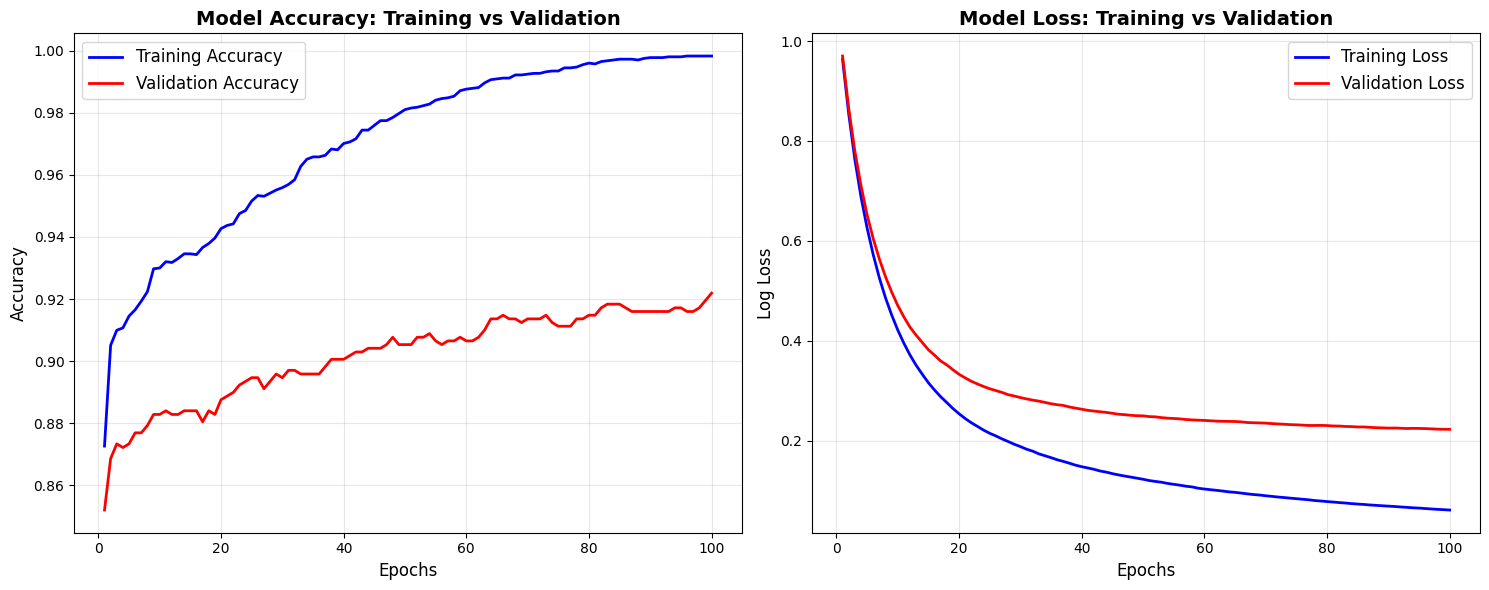

✓ Best validation accuracy: 0.9219 at epoch 100
✓ Best validation loss: 0.2225 at epoch 100


In [11]:
# ============================================================================
# STEP 11: PLOT TRAINING CURVES (ACCURACY AND LOSS)
# ============================================================================
gbm_classifier.plot_training_curves()


STEP 12: Plotting confusion matrices...


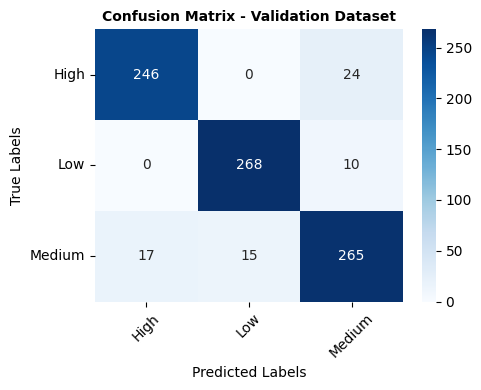

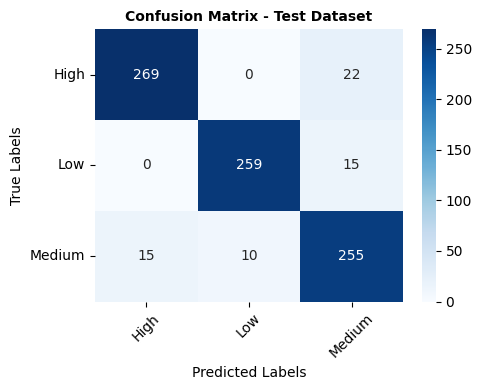

In [12]:
# ============================================================================
# STEP 12: PLOT CONFUSION MATRICES
# ============================================================================
print("\nSTEP 12: Plotting confusion matrices...")
gbm_classifier.plot_confusion_matrix(val_results, 'Validation')
gbm_classifier.plot_confusion_matrix(test_results, 'Test')


STEP 9C: Plotting top 20 feature importance...


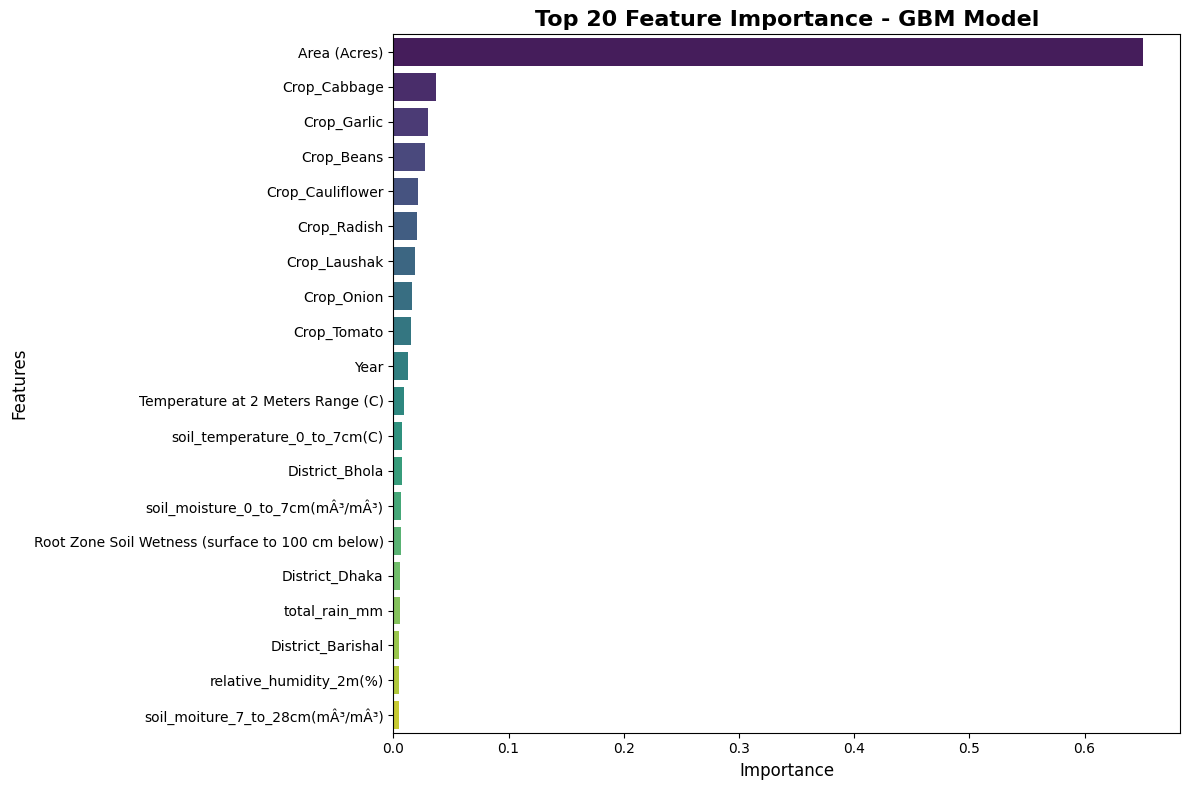

✓ Top 20 Most Important Features:
  Area (Acres): 0.6503
  Crop_Cabbage: 0.0374
  Crop_Garlic: 0.0296
  Crop_Beans: 0.0275
  Crop_Cauliflower: 0.0210
  Crop_Radish: 0.0209
  Crop_Laushak: 0.0186
  Crop_Onion: 0.0162
  Crop_Tomato: 0.0153
  Year: 0.0123
  Temperature at 2 Meters Range (C): 0.0089
  soil_temperature_0_to_7cm(C): 0.0076
  District_Bhola: 0.0071
  soil_moisture_0_to_7cm(mÂ³/mÂ³): 0.0070
  Root Zone Soil Wetness (surface to 100 cm below): 0.0062
  District_Dhaka: 0.0061
  total_rain_mm: 0.0058
  District_Barishal: 0.0052
  relative_humidity_2m(%): 0.0051
  soil_moiture_7_to_28cm(mÂ³/mÂ³): 0.0050


In [13]:
# ============================================================================
# STEP 13: PLOT FEATURE IMPORTANCE
# ============================================================================
gbm_classifier.plot_feature_importance()


STEP 14: Comparing validation vs test performance...


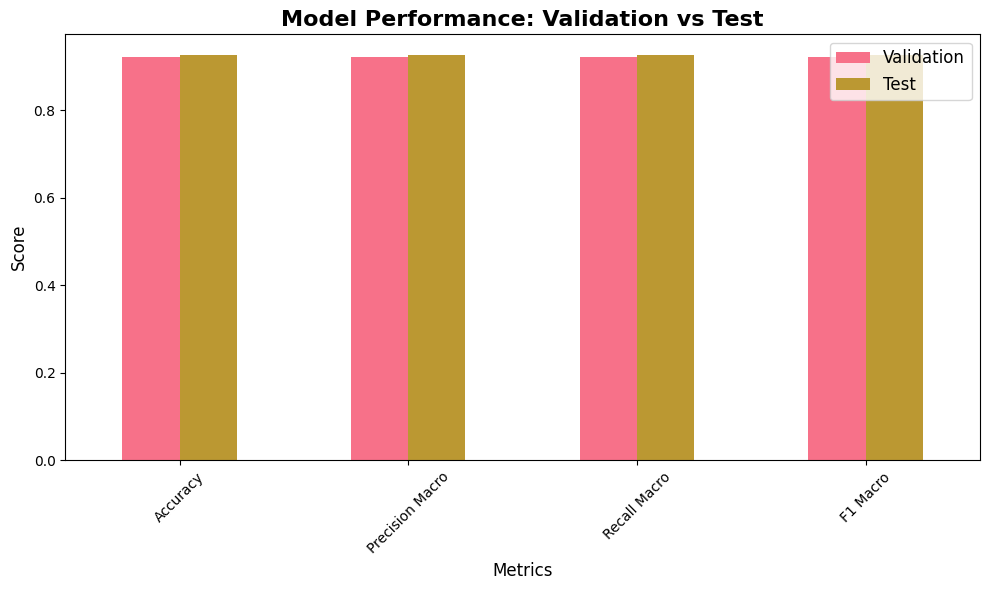

In [14]:
# ============================================================================
# STEP 14: PERFORMANCE COMPARISON
# ============================================================================
print("\nSTEP 14: Comparing validation vs test performance...")

def compare_models_performance(val_results, test_results):
    """Compare validation vs test performance"""
    metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

    comparison_df = pd.DataFrame({
        'Validation': [val_results[metric] for metric in metrics],
        'Test': [test_results[metric] for metric in metrics]
    }, index=[metric.replace('_', ' ').title() for metric in metrics])

    comparison_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Model Performance: Validation vs Test', fontsize=16, fontweight='bold')
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Metrics', fontsize=12)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return comparison_df

comparison_df = compare_models_performance(val_results, test_results)

In [15]:
# ============================================================================
# STEP 15: FINAL SUMMARY
# ============================================================================
print("\n" + "="*60)
print("FINAL SUMMARY OF RESULTS (3-LEVEL CLASSIFICATION)")
print("="*60)
print(f"✓ Validation Macro F1 Score: {val_results['f1_macro']:.4f}")
print(f"✓ Test Macro F1 Score: {test_results['f1_macro']:.4f}")
print(f"✓ Validation Accuracy: {val_results['accuracy']:.4f}")
print(f"✓ Test Accuracy: {test_results['accuracy']:.4f}")

print("\n" + "="*60)
print("✓ ALL STEPS COMPLETED SUCCESSFULLY!")
print("="*60)


FINAL SUMMARY OF RESULTS (3-LEVEL CLASSIFICATION)
✓ Validation Macro F1 Score: 0.9226
✓ Test Macro F1 Score: 0.9271
✓ Validation Accuracy: 0.9219
✓ Test Accuracy: 0.9266

✓ ALL STEPS COMPLETED SUCCESSFULLY!
